In [429]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
products=pd.read_csv("products.csv")
sales=pd.read_csv("sales.csv")
products=products.drop("Unnamed: 0",axis=1)
sales=sales.drop("Unnamed: 0",axis=1)
temp=sales[["invoice_date","total_sale"]]
sales["invoice_date"]=pd.to_datetime(sales["invoice_date"])
sales["week"]=pd.DatetimeIndex(sales["invoice_date"]).week
sales["month"]=pd.DatetimeIndex(sales["invoice_date"]).month
sales["year"]=pd.DatetimeIndex(sales["invoice_date"]).year
sales["weekday"]=pd.DatetimeIndex(sales["invoice_date"]).day_of_week

C:\Users\giorg\AppData\Local\Temp\ipykernel_14940\51261966.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  sales["week"]=pd.DatetimeIndex(sales["invoice_date"]).week


In [430]:
# Get a list of products that are above the 75th pctl in terms of
# volume sold
temp=sales.groupby(by="ASIN").sum().reset_index()
sales100=temp.loc[temp["total_sale"]>6.61e+04]
sales100=sales100.drop(["InvoiceNo", "Quantity", "price", 
        "invoice_time", "CustomerID"], axis=1)
# Get a list of products that are above the 75th pctl in terms of 
# total revenue
temp=sales.groupby(by="ASIN").sum().reset_index()
quantity100=temp.loc[temp["Quantity"]>1336]
quantity100=quantity100.drop(["InvoiceNo", "price", "total_sale", 
                "invoice_time", "CustomerID"],
                axis=1)
# Find the common items between the two lists
top100=pd.merge(sales100,quantity100,on="ASIN")

In [456]:
# Find the revenue per customer for each country 
temp=sales
temp["year"]=1
temp=temp.groupby(by="Country").sum()
temp.reset_index(inplace=True)
temp.drop(["InvoiceNo","Quantity","price","invoice_time","CustomerID",
    "week","month","weekday"],axis=1,inplace=True)
temp["rev_per_ca"]=temp["total_sale"]/temp["year"]
temp.sort_values(by="rev_per_ca",ascending=False)

,Country,total_sale,year,rev_per_ca
30,Sweden,4.353715e+06,426,10219.988427
18,Japan,3.048197e+06,319,9555.475831
22,Netherlands,2.169231e+07,2316,9366.280427
0,Australia,9.758509e+06,1243,7850.771448
7,Czech Republic,8.818802e+04,24,3674.500833
27,Singapore,7.362895e+05,217,3393.039309
15,Ireland,1.500259e+07,7186,2087.752516
16,Israel,4.641027e+05,240,1933.761333
8,Denmark,6.852961e+05,382,1793.968953
20,Lithuania,6.010738e+04,35,1717.353714


Text(0, 0.5, '')

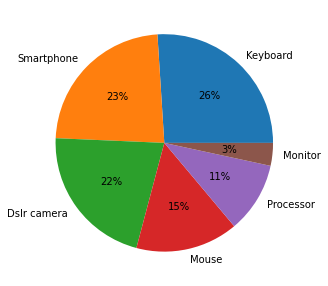

In [437]:
fig,ax=plt.subplots(figsize=(5,5))
temp=products["product_type"].value_counts()
label=[i for i in temp.index]
label=[i.capitalize() for i in label]
temp.plot.pie(
        labels=label, autopct="%1.0f%%")
ax.set_ylabel("")

Text(0, 0.5, 'Total sales (in 10s of million)')

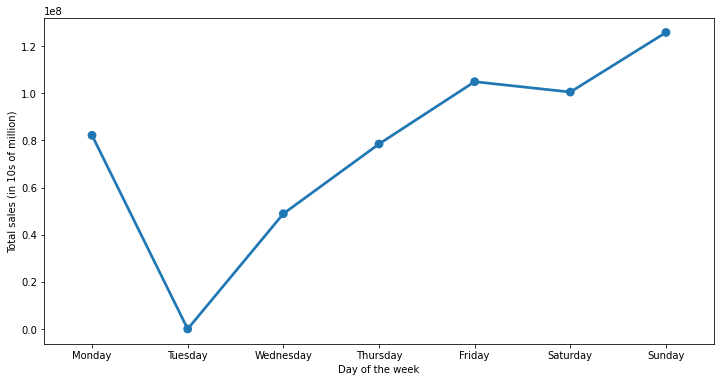

In [432]:
temp=sales.groupby(by="weekday").sum()
temp.drop(["InvoiceNo", "price", "Quantity", "invoice_time",
        "CustomerID", "week", "month", "year"], axis=1, inplace=True)
temp.reset_index(inplace=True)
# Since Tuesday has no sales, we have to insert the day to the dataframe
# We set the sale for that day to non zero temporarily so that they
# don't get renamed
temp.loc[0.5]=1,0.1
temp.replace({0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",
        4:"Friday",5:"Saturday",6:"Sunday"}, inplace=True)
temp.loc[0.5,"total_sale"]=0
temp=temp.sort_index().reset_index(drop=True)
# Snippet for normalising the total sale values
# temp["total_sale"]=temp["total_sale"].apply(lambda x:
#         (x-temp["total_sale"].mean())/temp["total_sale"].std())
fig,ax=plt.subplots(figsize=(12,6))
sns.pointplot(data=temp,x="weekday",y="total_sale")
plt.xlabel("Day of the week")
plt.ylabel("Total sales in 100s of millions")

[Text(0.5, 1.0, 'Monthly average revenue'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Revenue in 10s of millions')]

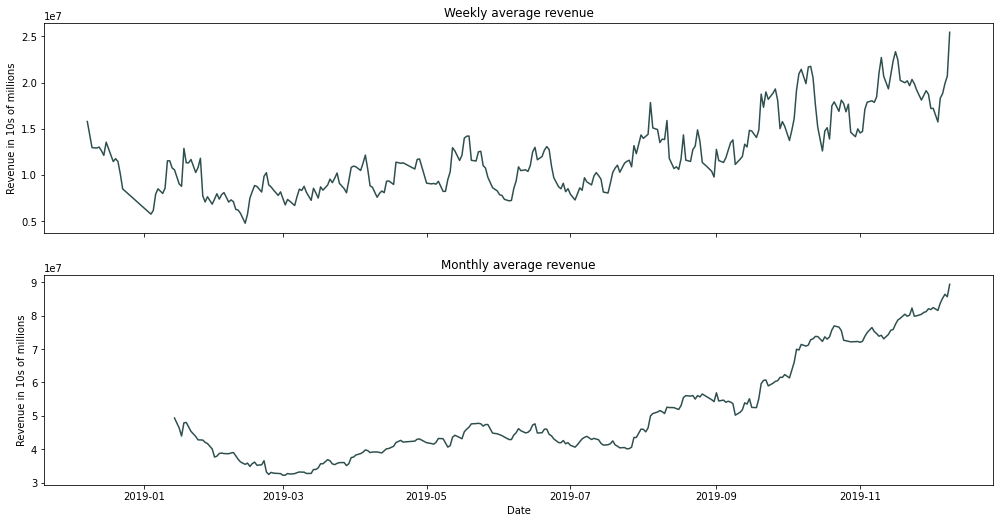

In [433]:
# Do it again but with better grouping and rolling averages
fig,ax=plt.subplots(2,1,figsize=(17,8.5),sharex=True)
temp=pd.merge(sales,products,on="ASIN")
temp=temp.groupby(by="invoice_date").sum()
temp.reset_index(inplace=True)
temp["avg"]=(temp["total_sale"].rolling(7).sum())
sns.lineplot(ax=ax[0],x=temp["invoice_date"], y=temp["avg"],
        color="darkslategrey")
temp["avg"]=(temp["total_sale"].rolling(30).sum())        
sns.lineplot(ax=ax[1],x=temp["invoice_date"], y=temp["avg"],
        color="darkslategrey")        
ax[0].set(title="Weekly average revenue", xlabel="", 
        ylabel="Revenue in 10s of millions")
ax[1].set(title="Monthly average revenue", xlabel="Date", 
        ylabel="Revenue in 10s of millions")

Text(0.5, 0, 'Date')

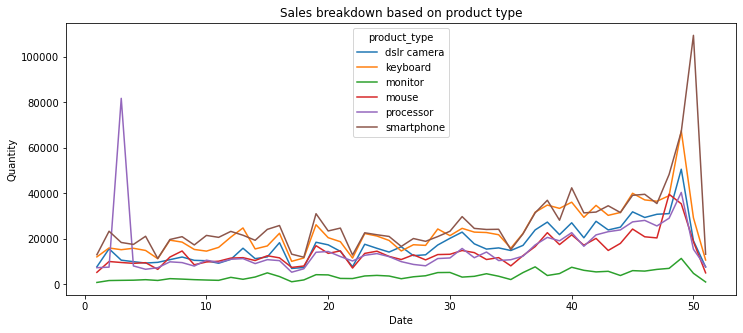

In [434]:
fig,ax=plt.subplots(figsize=(12,5))
temp=pd.merge(sales,products,on="ASIN")
temp=temp.groupby(by=["week","product_type"]).sum()
temp.reset_index(inplace=True)
sns.lineplot(x=temp["week"], y=temp["Quantity"],
        hue=temp["product_type"],
        color="darkslategrey")
plt.title("Sales breakdown based on product type")
plt.xlabel("Date")

In [438]:
temp=sales.loc[sales["year"]==2019]
temp=temp[["month","total_sale"]]
temp.set_index("month", inplace=True)
temp.index=pd.to_datetime(temp.index)

In [440]:
from statsmodels.tsa.seasonal import seasonal_decompose
dec=seasonal_decompose(temp["total_sale"], model="additive",period=12)
dec.trend.plot()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None